In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

years=14
dates = pd.date_range(start='2010-01-01', periods=12*years, freq='MS')

data=[]

n_stores = 5
n_products = 10
for store_id in range(n_stores):
    for product_id in range(n_products):
        for date in dates:
            sales = np.random.randint(10,100)
            prices = np.random.uniform(5,50)
            product_category = np.random.choice(['A','B','C'])
            store_size = np.random.choice([100,200,300])
            data.append([date,store_id,product_id,sales,prices,product_category,store_size])

df = pd.DataFrame(data, columns=['Date','store_id','product_id','sales','price','product_category','store_size'])
df['month_idx'] = df['Date'].dt.to_period('M').astype('category').cat.codes

df

,Date,store_id,product_id,sales,price,product_category,store_size,month_idx
0,2010-01-01,0,0,87,33.751029,C,100,0
1,2010-02-01,0,0,20,45.903261,C,200,1
2,2010-03-01,0,0,57,19.767624,B,200,2
3,2010-04-01,0,0,86,38.008063,C,200,3
4,2010-05-01,0,0,62,38.724067,C,200,4
...,...,...,...,...,...,...,...,...
8395,2023-08-01,4,9,51,36.991879,A,300,163
8396,2023-09-01,4,9,36,37.844619,B,100,164
8397,2023-10-01,4,9,58,21.161883,C,300,165
8398,2023-11-01,4,9,67,26.317413,B,300,166


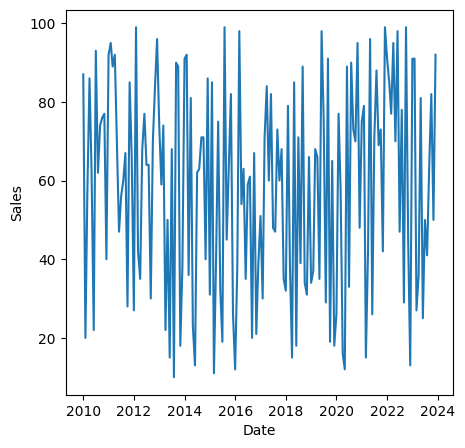

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(df[(df['store_id'] == 0) & (df['product_id'] ==0)]['Date'], df[(df['store_id'] == 0) & (df['product_id'] ==0)]['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [4]:
# Predictions:
max_encoder_length = 12*5 
max_prediction_length = 6
training_cutoff = "2022-12-01"  

In [5]:
from pytorch_forecasting import TimeSeriesDataSet

training = TimeSeriesDataSet(
    df[df['Date']<training_cutoff],
    time_idx = 'month_idx',
    target = 'sales',
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['product_category'],
    static_reals=['store_size'],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['price'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['sales'],
    group_ids=['store_id','product_id'],
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [6]:
batch_size = 24
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, persistent_workers=True)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size*10, num_workers=2, persistent_workers=True)

In [7]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [8]:
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import loggers as pl_loggers
tensorboard = pl_loggers.TensorBoardLogger('./')

pl.seed_everything(33)

early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=12, verbose=False, mode= 'min')
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs=100,
    accelerator = 'auto',
    gradient_clip_val=0.1,
    limit_train_batches = 100,
    callbacks = [lr_logger,early_stop_callback],
    logger = logger
)

Seed set to 33
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size = 6,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=6,
    output_size=7,
    loss=QuantileLoss(),
    optimizer='Adam',
    log_interval=2,
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 3.2k


Finding best initial lr: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]
Learning rate set to 0.24604310788528688
Restoring states from the checkpoint path at c:\Users\CarlosHerediaPimient\DataBricks\Forecasting\pytorch\.lr_find_90be8439-5f16-4336-8429-101843ae278f.ckpt
Restored all states from the checkpoint at c:\Users\CarlosHerediaPimient\DataBricks\Forecasting\pytorch\.lr_find_90be8439-5f16-4336-8429-101843ae278f.ckpt


suggested learning rate: 0.24604310788528688


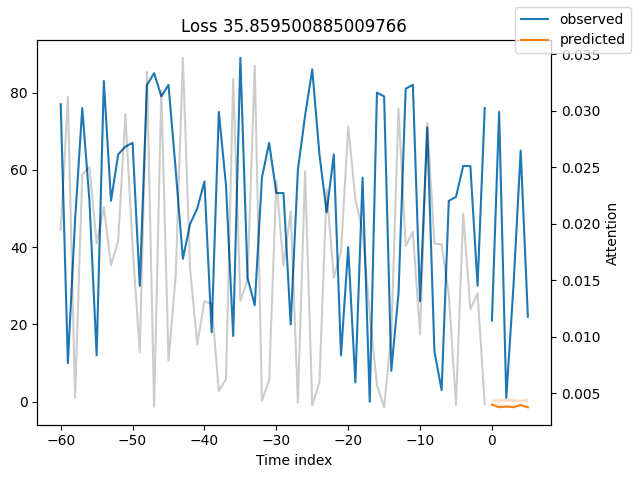

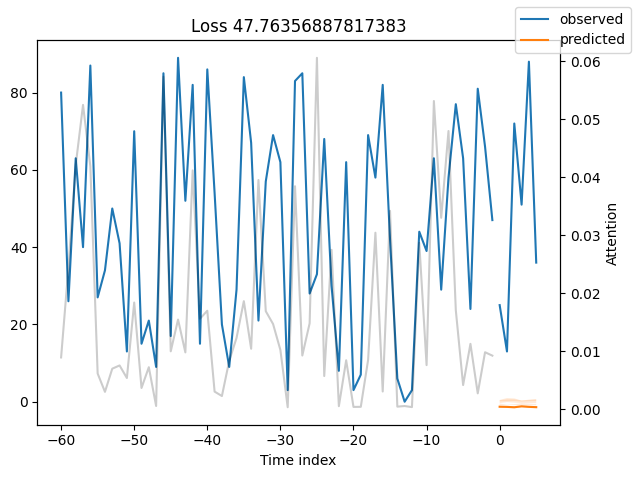

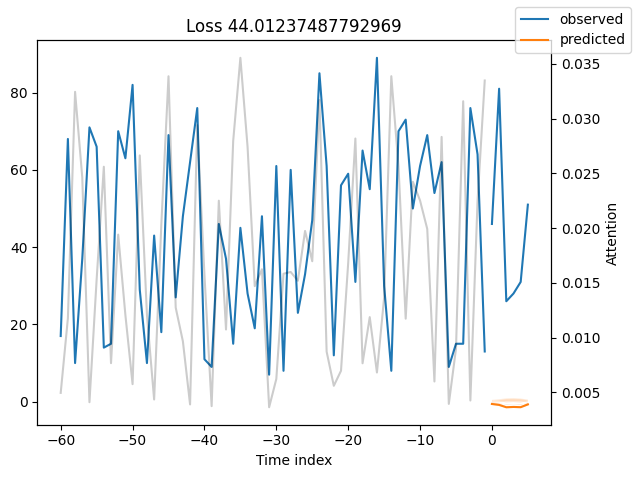

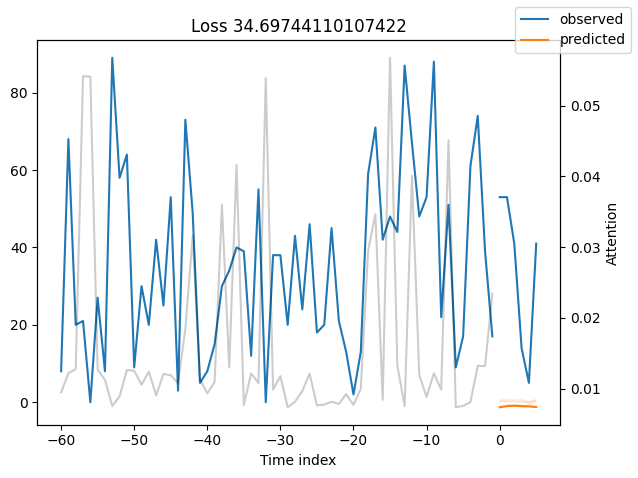

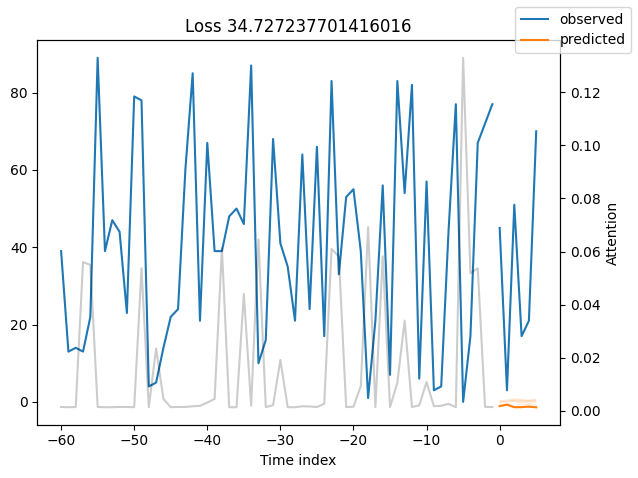

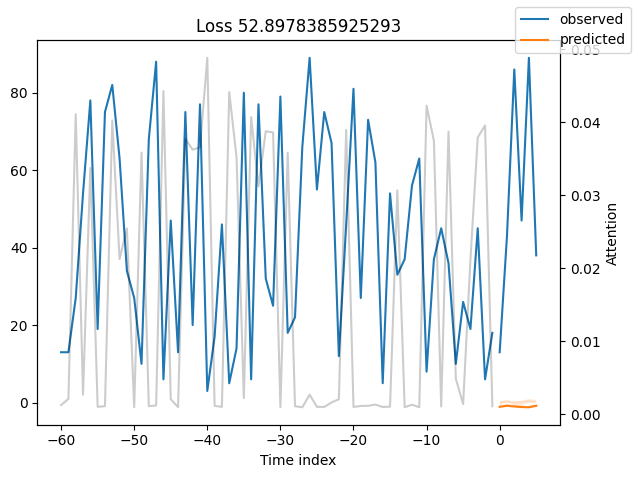

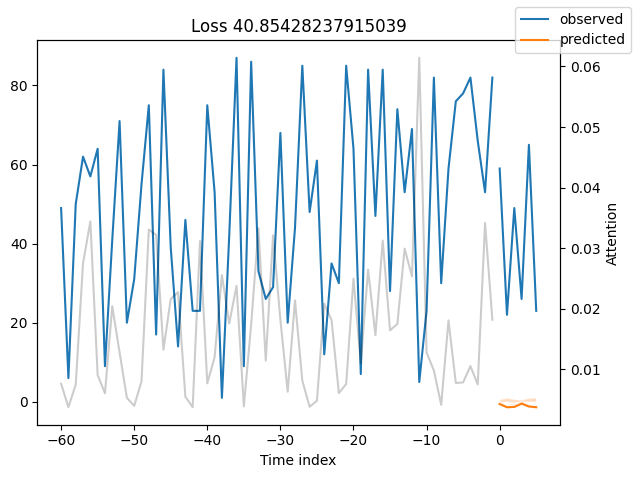

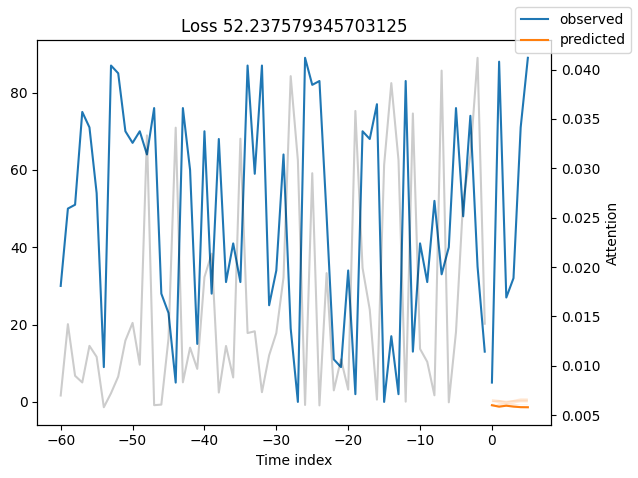

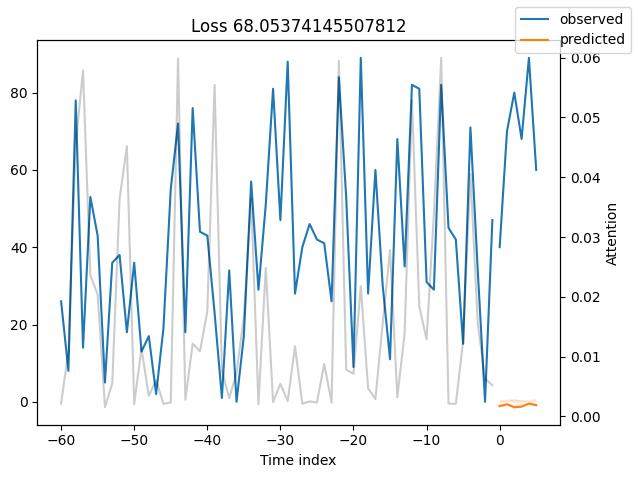

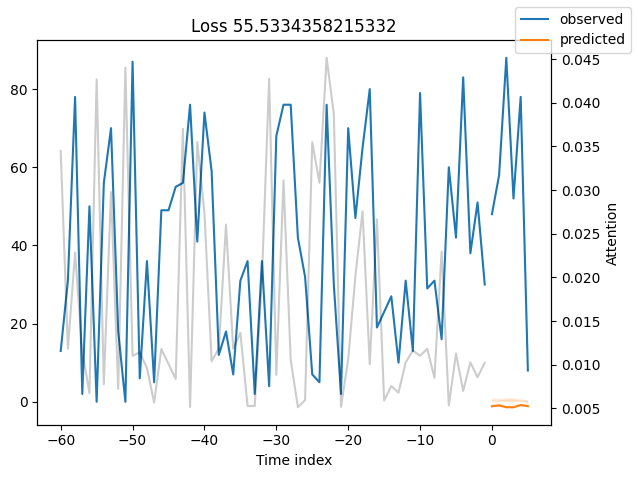

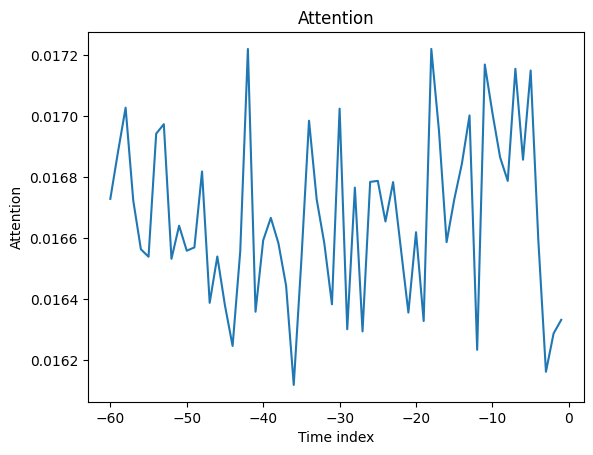

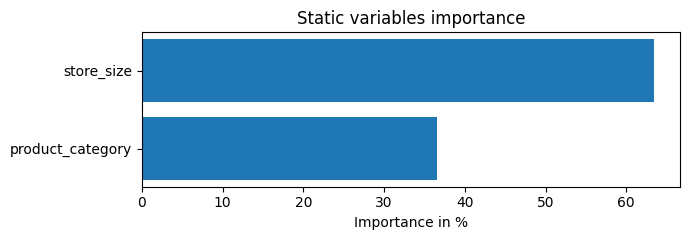

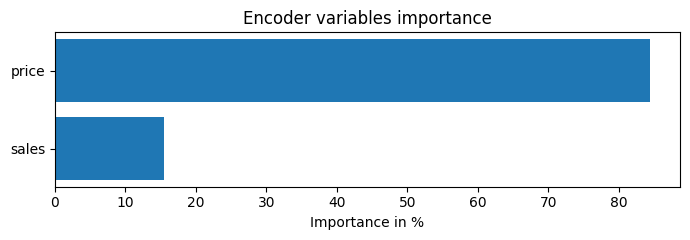

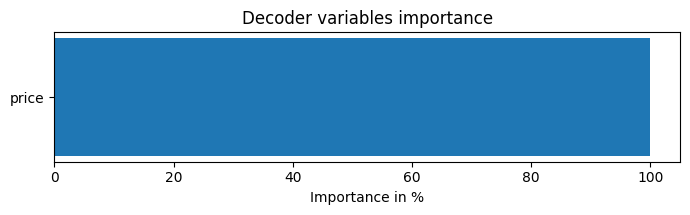

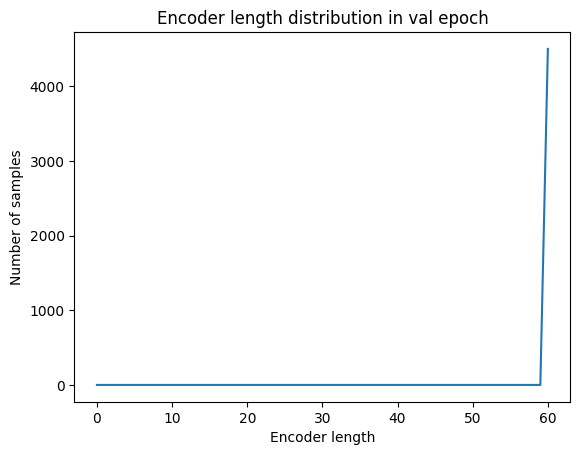

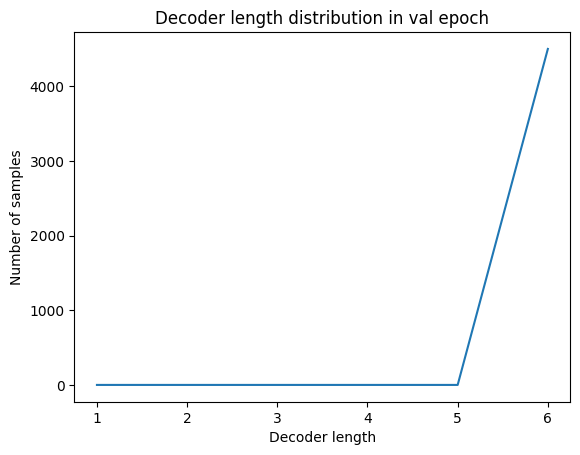

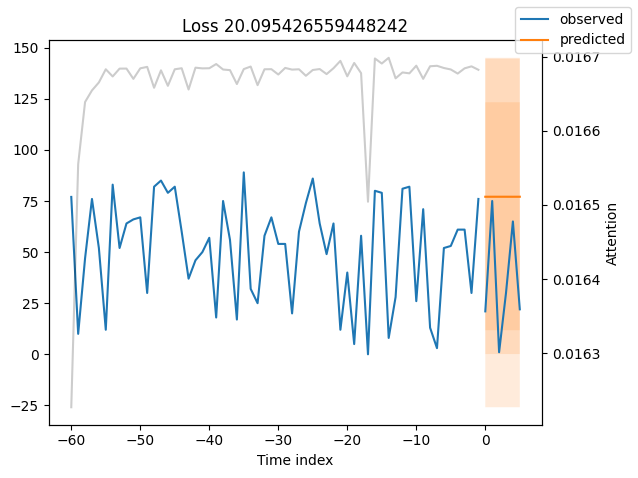

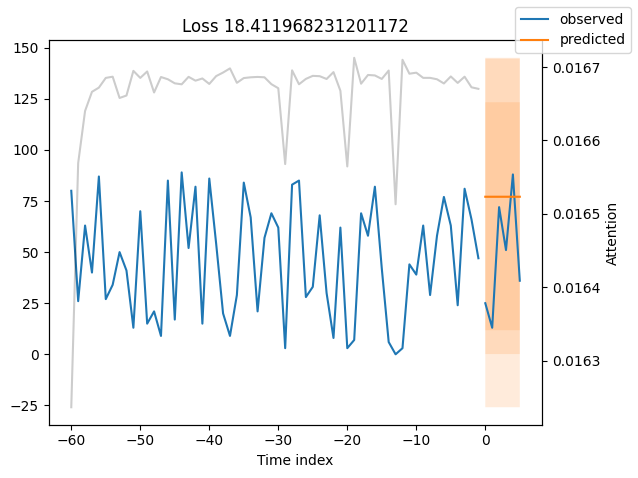

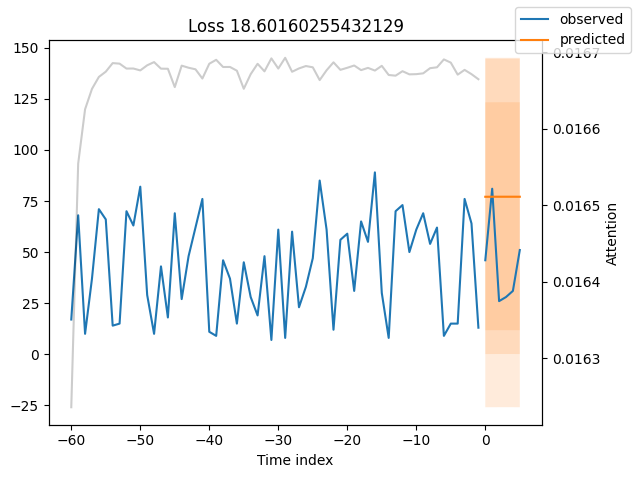

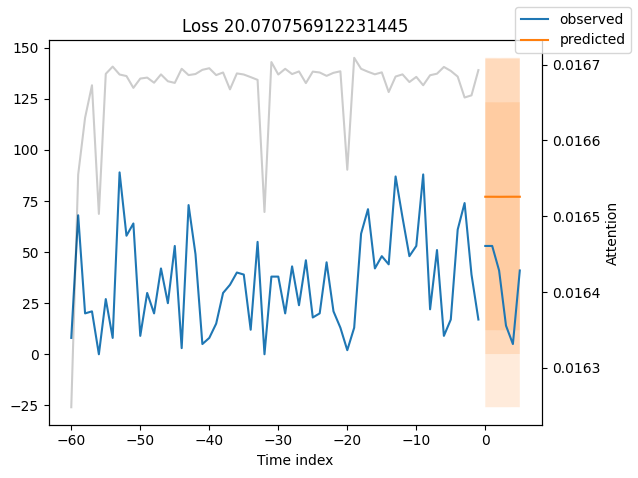

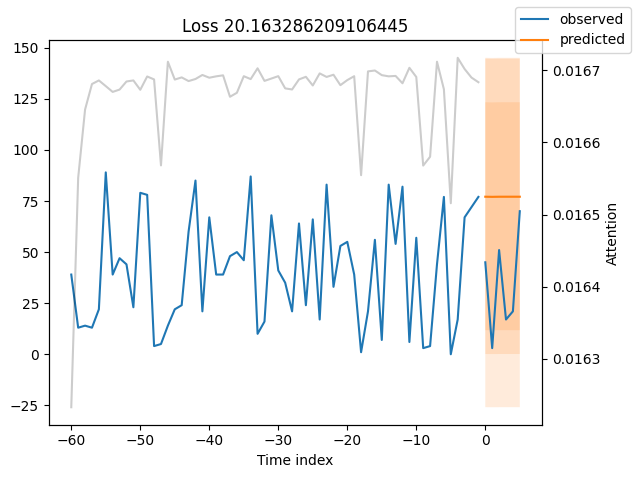

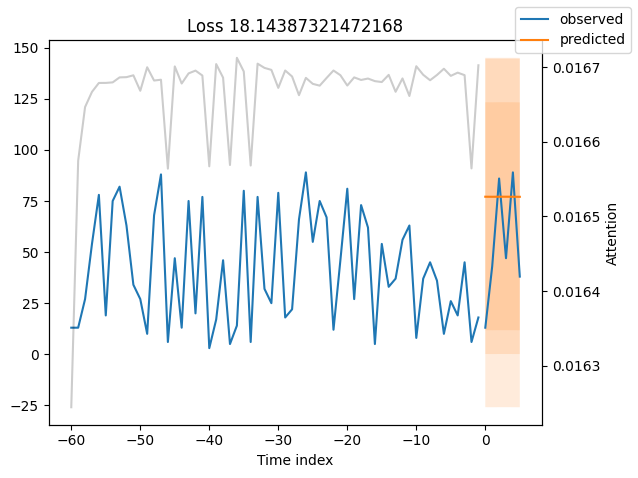

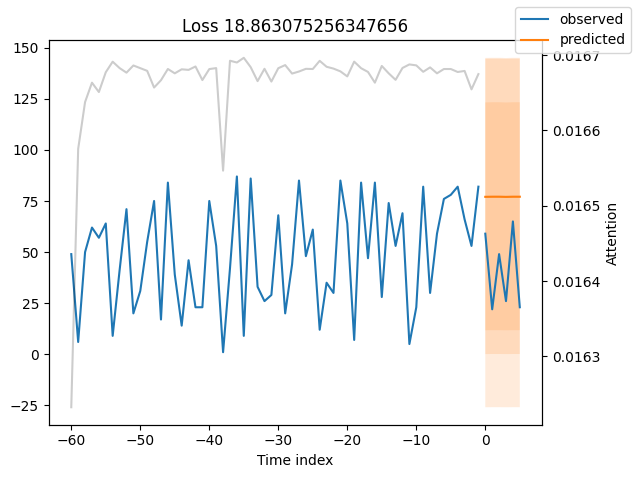

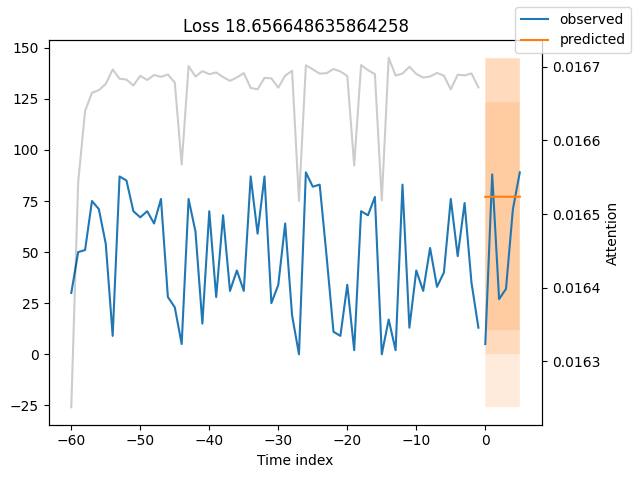

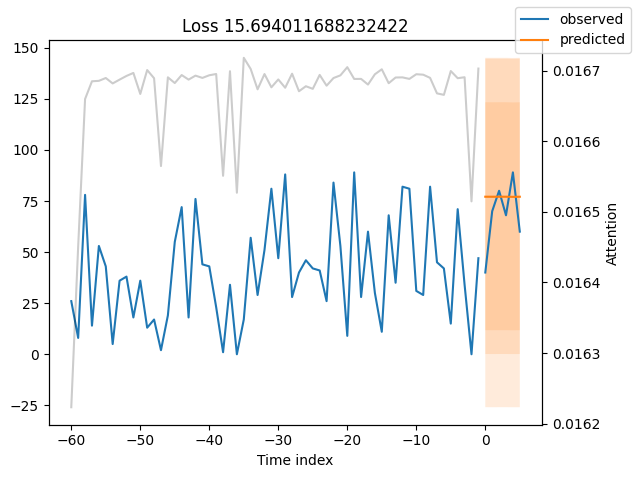

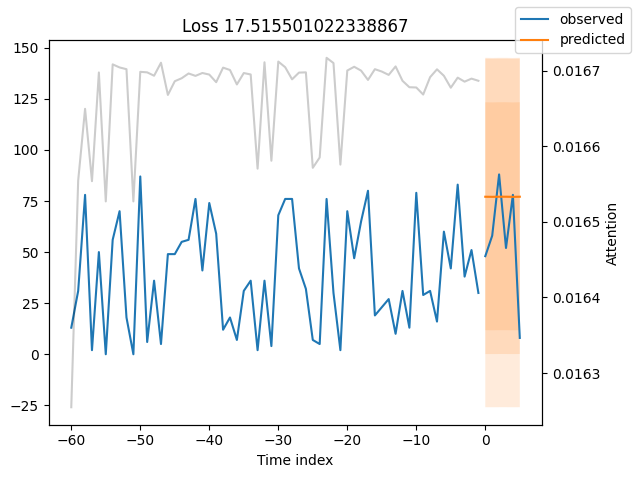

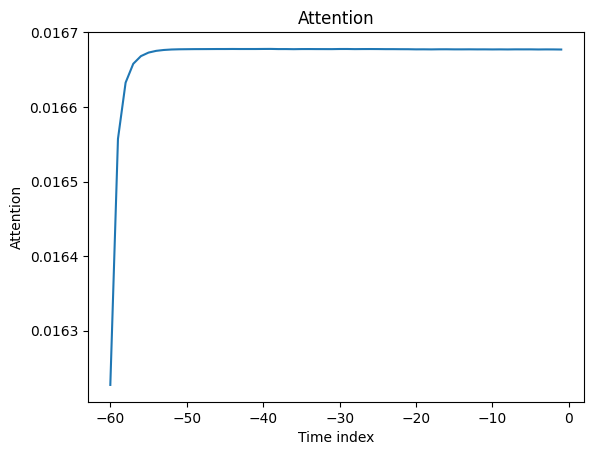

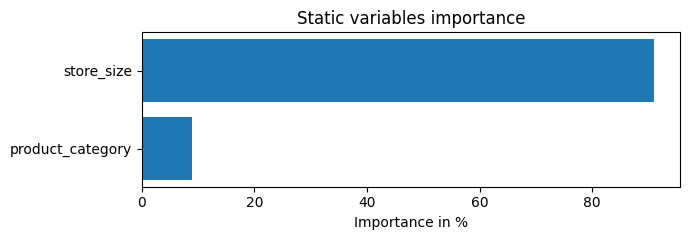

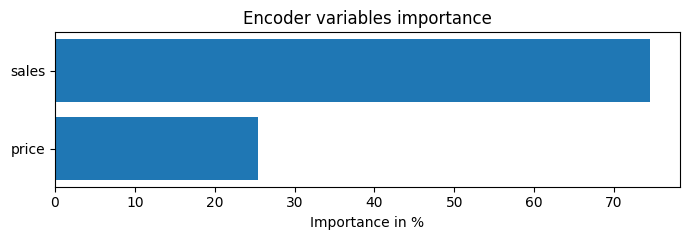

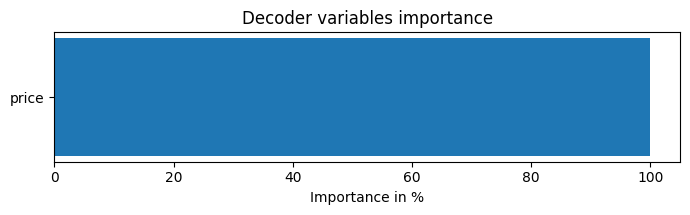

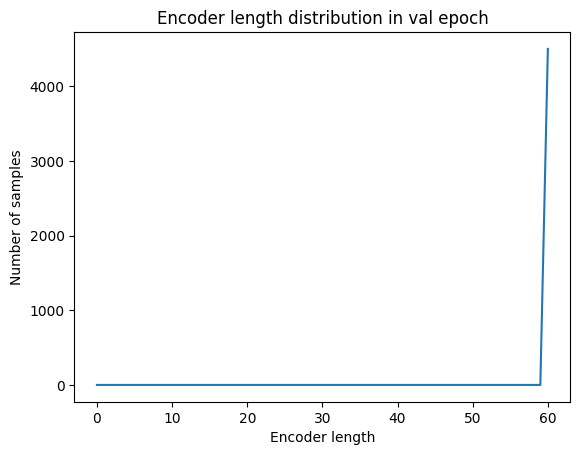

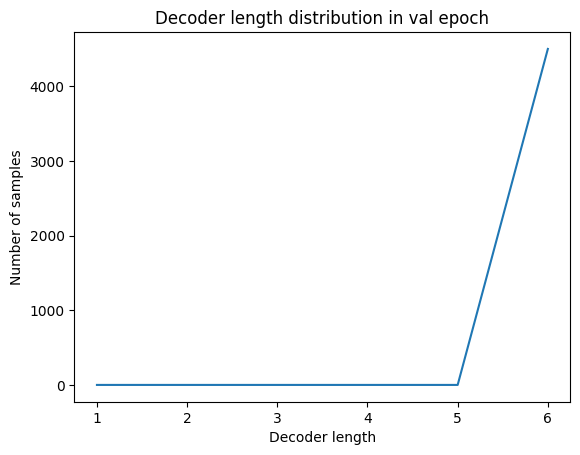

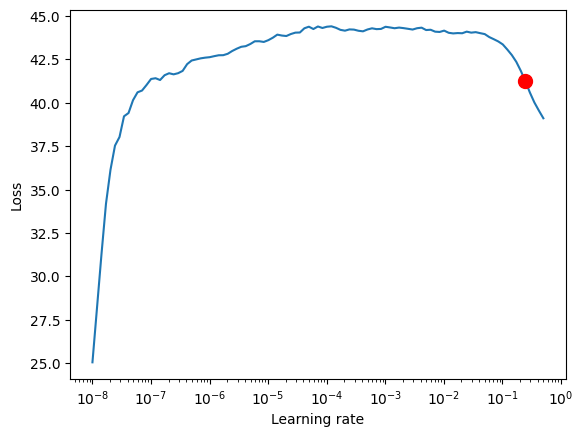

In [10]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.5,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [11]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 9     
3  | prescalers                         | ModuleDict                      | 36    
4  | static_variable_selection          | VariableSelectionNetwork        | 258   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 450   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 192   
7  | static_context_variable_selection  | GatedResidualNetwork            | 180   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 180   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 180 

Epoch 57: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s, v_num=2, train_loss_step=11.00, val_loss=11.00, train_loss_epoch=11.00]   
